## Learn on the first 10 seconds and then use a fixed model

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

def load_and_plot(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    plt.plot(data["time"], data[sensor])
    plt.title("Sensor's {} data". format(sensor))


#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

    

def simulation(dir_path, time_range, wait_time = 10):
    
    #Obtain the train and test time
    train_range = (time_range[0], time_range[0] + wait_time)
    test_range = (time_range[0] + wait_time, time_range[1])
                  
    X_train, train_time = generate_data(dir_path, time_range = train_range, window = 2000, step = 10)
    X_test, test_time = generate_data(dir_path, time_range = test_range, window = 2000, step = 10)
    print("X_train's shape: ", X_train.shape)
    print("X_test's shape: ", X_test.shape)
    
    #Scaling of data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = create_model()
    
    # Train model for 50 epochs, batch size of 1028: 
    NUM_EPOCHS=50
    BATCH_SIZE=1028

    history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)
    
    #Plot the training log
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'],'r',label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mse]')
    plt.show()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Obtain the log loss mean
    train_mean = np.mean(np.log10(loss))
    
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss) - train_mean
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(test_time, log_test_loss, color = "firebrick")
    plt.title("Reconstruction loss on {}".format(test_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Plot the reconstruction loss in last 20 seconds
    plt.figure(figsize=(20,2))
    plt.plot(test_time, log_test_loss)
    plt.title("Reconstruction loss on {}".format((-20,0)))
    plt.xlim((-20,0))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Trigger system
    trigger_index = np.argmax(log_test_loss > 4)
    print("Trigger time is ", test_time[trigger_index])

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3897500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3897500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 2s 19us/step - loss: 0.0123 - val_loss: 0.0059
Epoch 2/50
87750/87750 [==============================] - 1s 6us/step - loss:

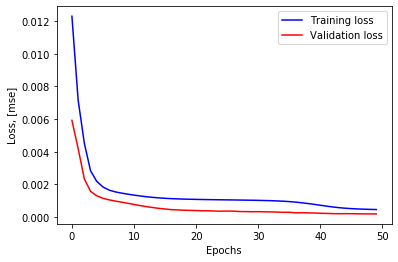

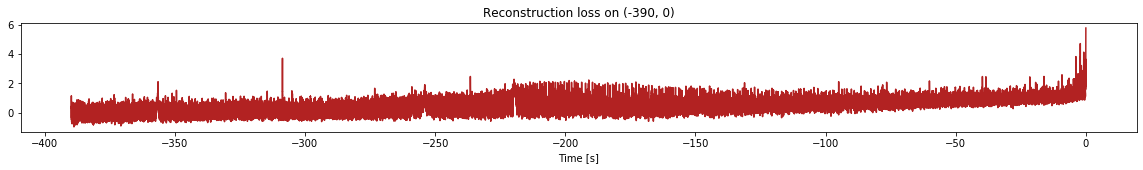

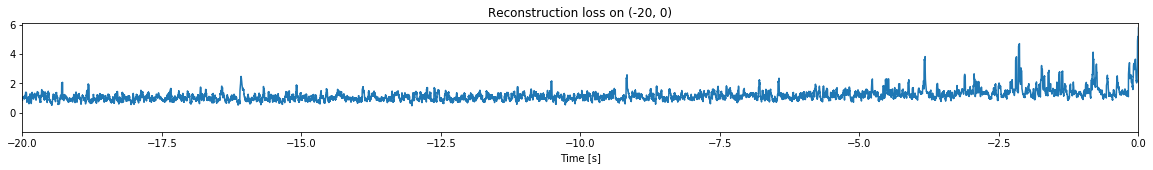

Trigger time is  -2.15118


In [3]:
simulation("./data/Ramp4/", time_range = (-400,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3897500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3897500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 16us/step - loss: 0.0073 - val_loss: 0.0038
Epoch 2/50
87750/87750 [==============================] - 0s 5us/step - loss:

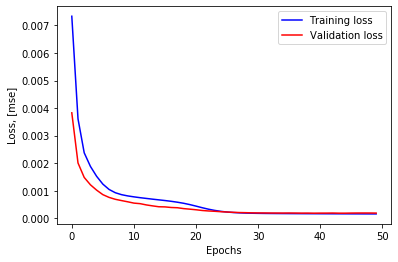

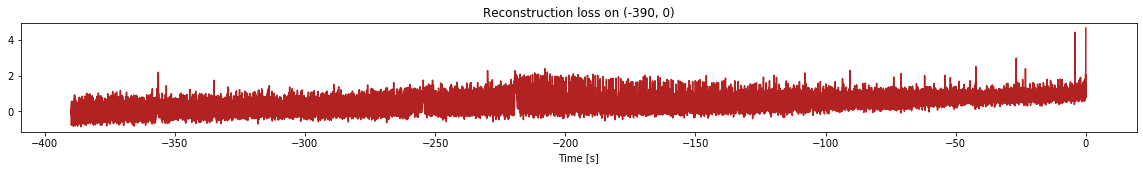

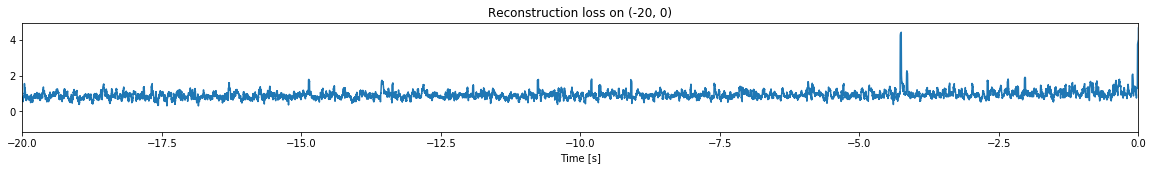

Trigger time is  -4.2690797


In [4]:
simulation("./data/Ramp5/", time_range = (-400,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (2897500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (2897500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 16us/step - loss: 0.0299 - val_loss: 0.0142
Epoch 2/50
87750/87750 [==============================] - 0s 4us/step - loss:

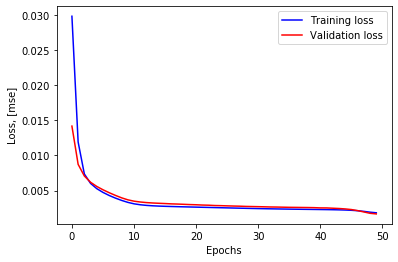

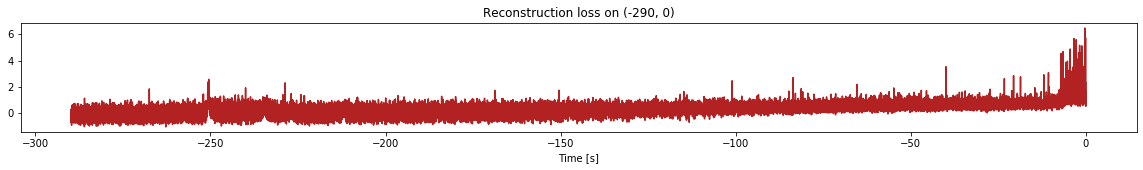

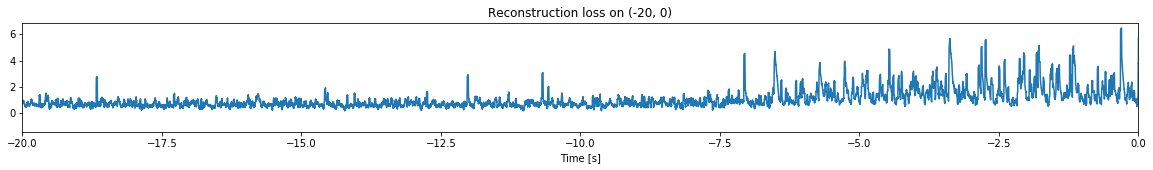

Trigger time is  -7.07219


In [5]:
simulation("./data/Ramp12d/", time_range = (-300,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3097500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3097500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 13us/step - loss: 0.0203 - val_loss: 0.0134
Epoch 2/50
87750/87750 [==============================] - 0s 5us/step - loss:

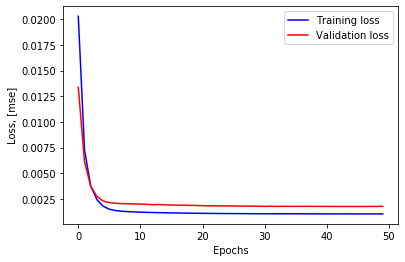

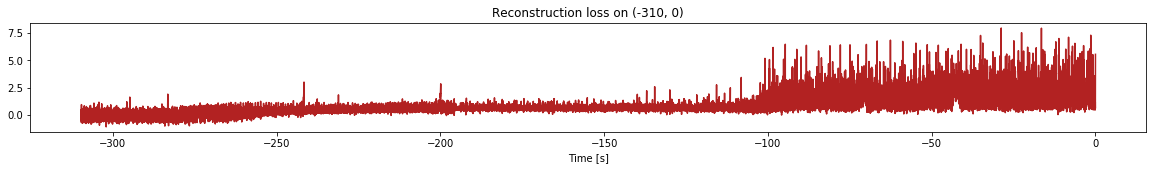

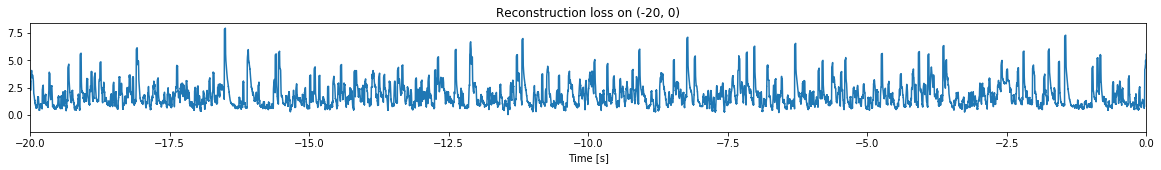

Trigger time is  -100.93159


In [6]:
simulation("./data/Ramp19/", time_range = (-320,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3097500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3097500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 14us/step - loss: 0.0034 - val_loss: 9.5328e-04
Epoch 2/50
87750/87750 [==============================] - 0s 5us/step - l

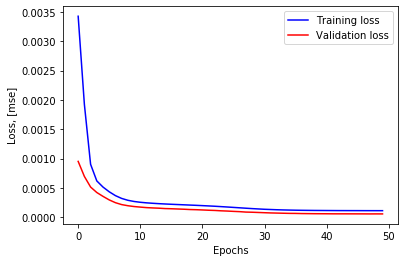

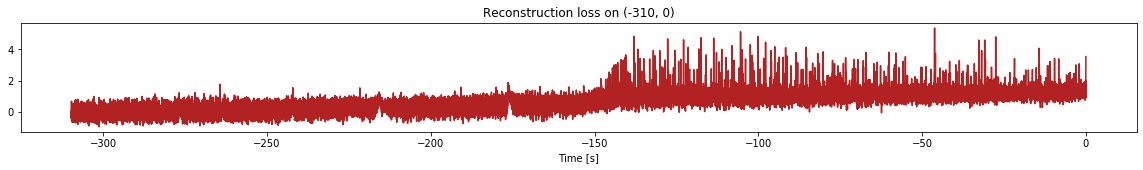

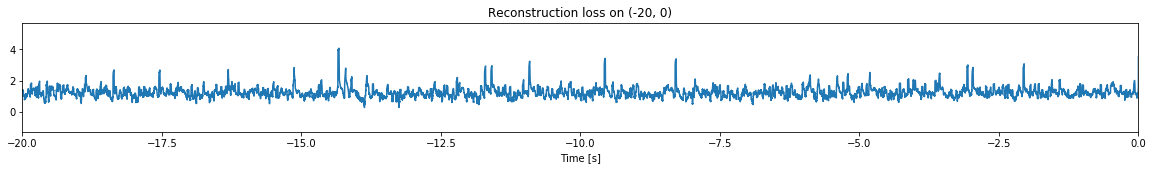

Trigger time is  -137.94319


In [7]:
simulation("./data/Ramp20/", time_range = (-320,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3897500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3897500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 14us/step - loss: 0.0202 - val_loss: 0.0115
Epoch 2/50
87750/87750 [==============================] - 0s 5us/step - loss:

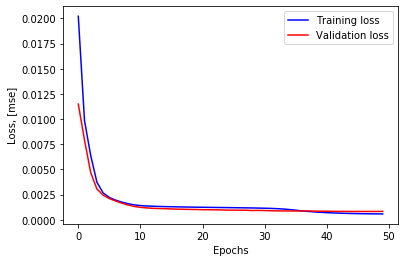

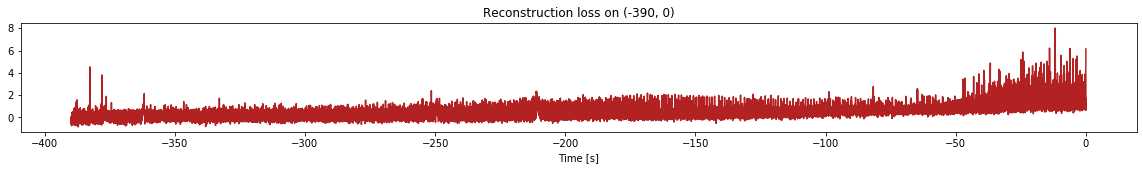

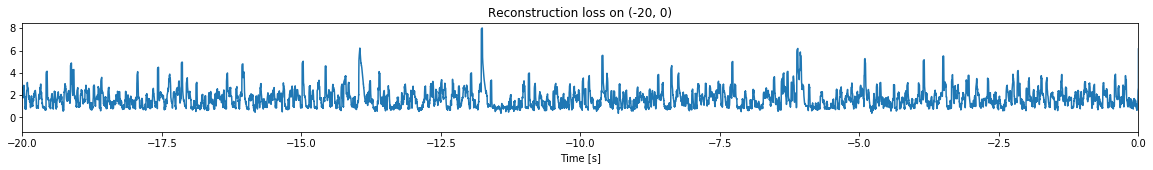

Trigger time is  -382.65375


In [8]:
simulation("./data/Ramp21/", time_range = (-400,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (97500, 12)
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (3897500, 12)
Flushing input history
X_train's shape:  (97500, 12)
X_test's shape:  (3897500, 12)
Train on 87750 samples, validate on 9750 samples
Epoch 1/50
87750/87750 [==============================] - 1s 13us/step - loss: 0.0023 - val_loss: 2.6400e-04
Epoch 2/50
87750/87750 [==============================] - 0s 4us/step - l

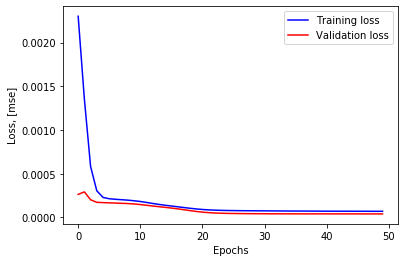

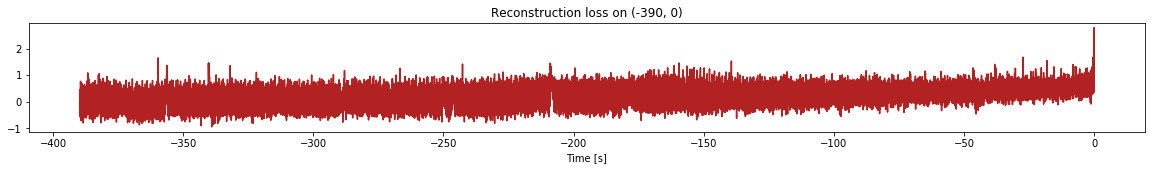

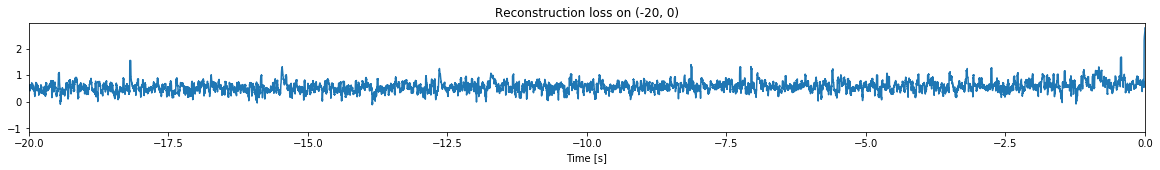

Trigger time is  -389.75


In [9]:
simulation("./data/Ramp22/", time_range = (-400,0))